# Example of modular usage

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm
from matplotlib import colors

from astropy.coordinates import SkyCoord
from astropy import units as u

from datetime import datetime
now = datetime.now().strftime("%y%m%d-%H%M%S")
hour = datetime.now().strftime("%y%m%d-%H")
today = datetime.now().strftime("%y%m%d")

from bowshockpy import NarrowJet
from bowshockpy.models import ObsModel, BowshockCube
from bowshockpy import utils as ut
from bowshockpy import moments
from bowshockpy import __version__

# TODO erease these lines
%load_ext autoreload
%autoreload 2

In [2]:
__version__

'0.2.0'

In [3]:
distpc = 300

# name of the model
modelname =  f"example_{now}"

# Characteristic lenght scale of the bowshock [km] 
# L0 = (0.591 * distpc * u.au).to(u.km).value
L0 = (0.391 * distpc * u.au).to(u.km).value

# distance from the source to the internal working surface [km]
zj = (4.58 * distpc * u.au).to(u.km).value 
# zj = (2.58 * distpc * u.au).to(u.km).value 

# velocity of the internal working surface [km/s]
vj = 111.5                                    

# velocty of the ambient [km/s]
va = 0                                      

# velocity at which the material is ejected sideways [km/s]
v0 = 22.9                                    
# v0 = 10

# total mass of the bowshock shell [Msun]
mass = 0.000231                               

# final radius of the bowhsock [km]
rbf_obs = (0.75 * distpc * u.au).to(u.km).value


In [4]:
bowshock_model = NarrowJet(
    L0=L0, zj=zj, vj=vj,
    va=va, v0=v0, mass=mass,
    rbf_obs=rbf_obs, distpc=distpc,
    )

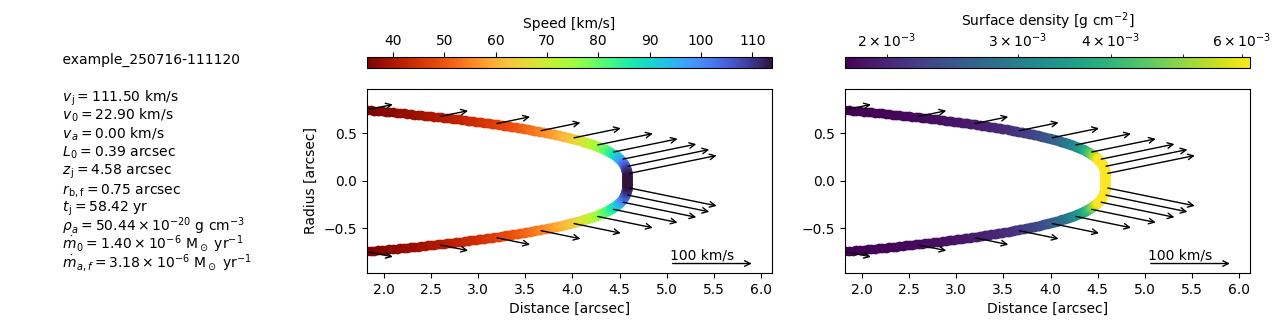

In [5]:
plt_model = bowshock_model.modelplot(
    modelname=modelname,
#    v_arrow_ref=100,
#    figsize=(16,3),
#    textbox_widthratio=0.7,
 )
plt_model.plot()
plt_model.savefig()

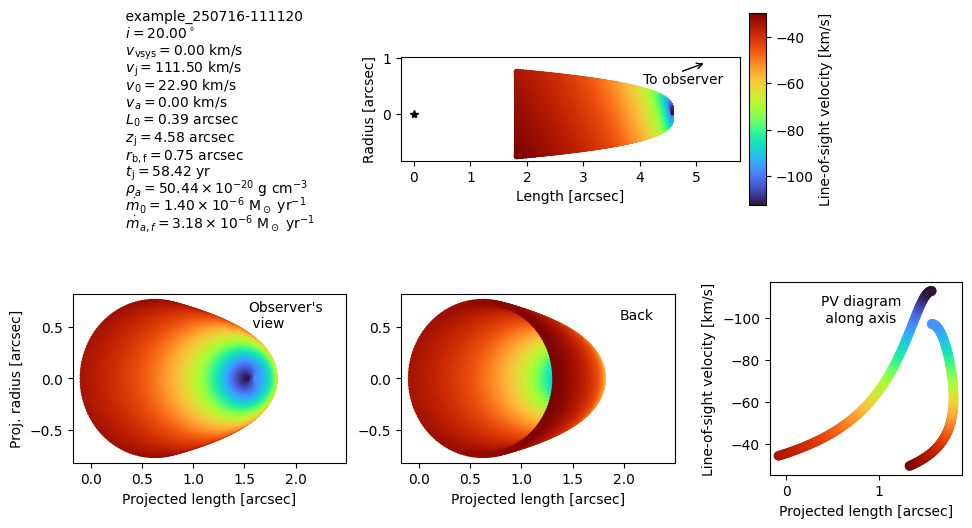

In [6]:
bowshock_obs = ObsModel(
    bowshock_model,
    i=20.0*np.pi/180,
    vsys=0,
    )

plt_obsmodel = bowshock_obs.modelplot(
    modelname=modelname,
    figsize=(12, 6),
    maxpointsize=10,
    # minpointsize=0.1,
    )

plt_obsmodel.plot()
plt_obsmodel.savefig(figname="models/prueba.jpg", dpi=300)

In [34]:
bowshock_cube = BowshockCube(
    bowshock_obs,
    nphis=300,
    nzs=200,
    nc=50,
    vch0=-10, 
    vchf=-120,
    xpmax=4,    
    nxs=150,
    nys=150, 
    refpix=[25*3, 10*3], 
    CIC=True,
    vt="2xchannel",
    tolfactor_vt=5,
    verbose=True,
    )
bowshock_cube.makecube()


Computing masses...
  0──────────────────────────────────────────────────)100.0% | 11/13s
Checking total mass consistency...
Only 1.5e-03 % of the total mass is lost due to numerical errors


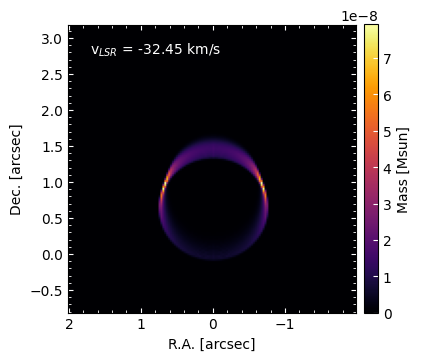

In [35]:
bowshock_cube.plot_channel(chan=10)

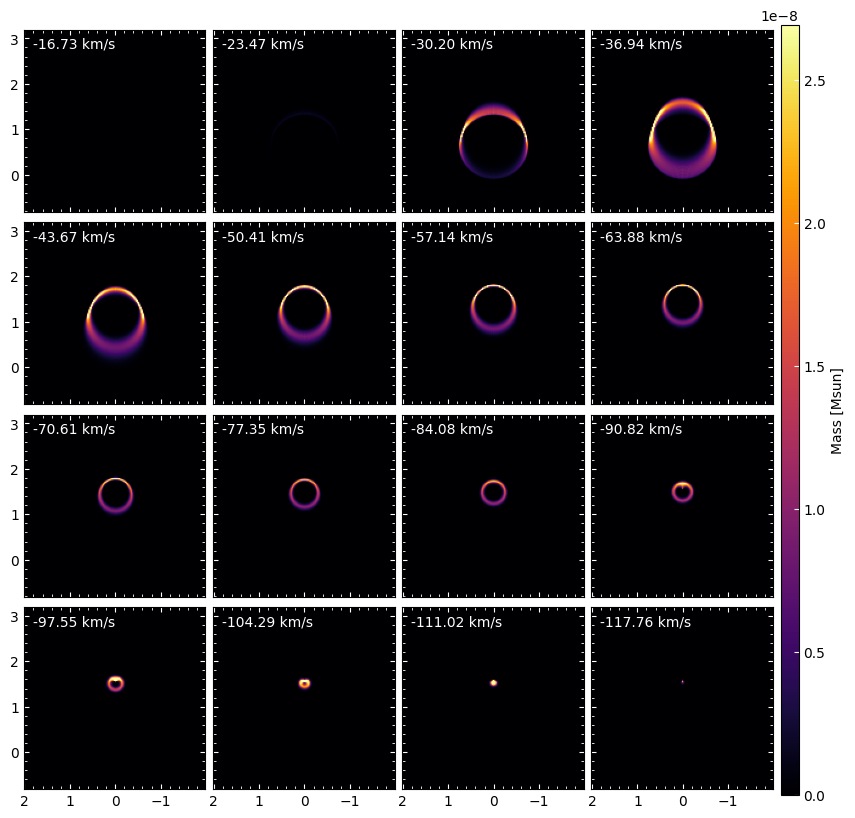

In [37]:
from itertools import product
from matplotlib import ticker


ncol = 4
nrow = 4
figsize = None
wspace = 0.05
hspace = 0.0
vmax = None
vcenter = None
vmin = None
cmap = "inferno"
velchans = bowshock_cube.velchans
cube = bowshock_cube.cube
nc = bowshock_cube.nc
refpix = bowshock_cube.refpix
arcsecpix = bowshock_cube.arcsecpix
units = "Mass [Msun]"
xmajor_locator = 1
xminor_locator = 0.2
ymajor_locator = 1
yminor_locator = 0.2

size_factor = 2.5
figsize = figsize if figsize is not None \
    else (ncol*size_factor, nrow*size_factor)
fig = plt.figure(figsize=figsize)
gs = GridSpec(nrow, ncol+1, 
              height_ratios=[1]*nrow,
              width_ratios=[1]*ncol+[0.1])

gs.update(wspace=wspace, hspace=hspace)

axs = {}
for n, (i,j) in enumerate(product(np.arange(nrow), np.arange(ncol))):
    axs[n] = plt.subplot(gs[i,j])
ax_cbar = plt.subplot(gs[:, ncol])

nchanscube = nrow*ncol
chans_plot = nc 
selint = int(chans_plot/nchanscube)
initchan = selint 
vmin = vmin if vmin is not None else np.min(cube)
vmax = vmax if vmax is not None else np.percentile(cube, 99.9)
vcenter = vcenter if vcenter is not None else (vmax - vmin) / 2.
norm = colors.TwoSlopeNorm(vmax=vmax, vcenter=vcenter, vmin=vmin)
    
iter_grid = [
    i for i in product(
        [i for i in range(nrow)],
        [j for j in range(ncol)]
    )
]

_, nys, nxs = np.shape(cube)
extent = np.array(
    [-(-0.5-refpix[0]),
     -(nxs-0.5-refpix[0]),
     (-0.5-refpix[1]),
     (nys-0.5-refpix[1]),
    ]) * arcsecpix
 
for chan, (i, j) in enumerate(iter_grid):
    data = cube[initchan::selint][chan]
    im = axs[chan].imshow(
        data,
        origin="lower",
        extent=extent,
        norm=norm,
        cmap="inferno",
    )   
    axs[chan].set_aspect("equal")
   
    axs[chan].text(0.05, 0.9,
            s=f"{velchans[initchan::selint][chan]:.2f} km/s",
            color="w",
            transform=axs[chan].transAxes,
            fontsize=10)
    axs[chan].tick_params(
        which="both",
        top=True,
        right=True,
        direction="in",
        color="w",
    )
    axs[chan].xaxis.set_major_locator(
        ticker.MultipleLocator(xmajor_locator))    
    axs[chan].yaxis.set_major_locator(
        ticker.MultipleLocator(ymajor_locator))    
    axs[chan].xaxis.set_minor_locator(
        ticker.MultipleLocator(xminor_locator))    
    axs[chan].yaxis.set_minor_locator(
        ticker.MultipleLocator(xminor_locator))    
    if (j > 0) and (i < nrow-1):
        axs[chan].set_xticklabels([])
        axs[chan].set_yticklabels([])
    if (i == (nrow-1)) and (j > 0):
        axs[chan].set_yticklabels([])
    if (i < (nrow-1)) and (j == 0):
        axs[chan].set_xticklabels([])
    
cbar = plt.colorbar(
       cm.ScalarMappable(
           norm=norm,
           cmap=cmap,
       ),
       cax=ax_cbar,
       orientation="vertical",
)

ax_cbar.set_ylabel(units)
ax_cbar.tick_params(
    axis="y", right=True, left=False,
    labelright=True, direction="in", color="w")
 

# fig.savefig(f'channels_{bk}.pdf',
#             bbox_inches="tight")

In [ ]:
bk = "td_ricC10"
#kopstr = re.findall("o\d+", bk)
#if kopstr != []:
#    kop = float(kopstr[0].lstrip("o"))
#else:
#    kop = 0

ncol = 5
nrow = 5
wspace = 0.05
hspace = 0.0

size_factor = 2.5
figsize = (ncol*size_factor, nrow*size_factor)
fig = plt.figure(figsize=figsize)
gs = GridSpec(nrow, ncol+1, 
              height_ratios=[1]*nrow,
              width_ratios=[1]*ncol+[0.1])

gs.update(wspace=wspace, hspace=hspace)

axs = {}
for n, (i,j) in enumerate(product(np.arange(nrow), np.arange(ncol))):
    axs[n] = plt.subplot(gs[i,j])
ax_cbar = plt.subplot(gs[:, ncol])

nchanscube = nrow*ncol
chans_plot = nchans
selint = int(chans_plot/nchanscube)
initchan = selint 
alldata = cube[initchan::selint]
vmax = None
fvcenter = 0.5
if vmax is None:
    uplim = np.max(alldata)
    norm = TwoSlopeNorm(vcenter=uplim*fvcenter, vmax=uplim, vmin=0)
else:
    vmin = vmin if vmin is not None else 0
    vcenter = vcenter if vcenter is not None else (vmax - vmin) / 2.
    norm = TwoSlopeNorm(vmax=vmax, vcenter=vcenter, vmin=vmin)
    
iter_grid = [
    i for i in product(
        [i for i in range(nrow)],
        [j for j in range(ncol)]
    )
]
for chan, (i, j) in enumerate(iter_grid):
    data = cubes[bk][initchan::selint][chan]
    im = axs[chan].imshow(
        data,
        origin="lower",
        extent=[-xpmax/2, xpmax/2, -xpmax/2, xpmax/2],
        interpolation="bilinear",
        cmap="inferno",
    )   
    axs[chan].set_aspect("equal")
   
    axs[chan].text(0.05, 0.9,
            s=f"{vchans[initchan::selint][chan]:.2f} km/s",
            color="w",
            transform=axs[chan].transAxes,
            fontsize=10)
    axs[chan].tick_params(
        which="both",
        top=True,
        right=True,
        direction="in",
        color="w",
    )
    axs[chan].xaxis.set_major_locator(ticker.MultipleLocator(0.1))    
    axs[chan].xaxis.set_minor_locator(ticker.MultipleLocator(0.02))    
    axs[chan].yaxis.set_major_locator(ticker.MultipleLocator(0.1))    
    axs[chan].yaxis.set_minor_locator(ticker.MultipleLocator(0.02))       
    if (j > 0) and (i < nrow-1):
        axs[chan].set_xticklabels([])
        axs[chan].set_yticklabels([])
    if (i == (nrow-1)) and (j > 0):
        axs[chan].set_yticklabels([])
    if (i < (nrow-1)) and (j == 0):
        axs[chan].set_xticklabels([])
    
pa = pars['pabeam'] * np.pi/180. + np.pi/2
# in radians
a = pars['ybeamC10'] #/ pars['arcsecpix']
# semi-major axis in pixels
b = pars['xbeamC10'] #/ pars['arcsecpix']   #semi-minor axis in pixels
xpos = -0.063
ypos = -0.07
geometry = EllipseGeometry(x0=xpos, y0=ypos,
                           sma=a*0.5, eps=(1-b/a), pa=pa)
aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                           geometry.sma*(1 - geometry.eps),
                           geometry.pa)
   
aper.plot(axs[nrow*(ncol-1)],
          color="w",
          linewidth=2,
          transform=axs[nrow*(ncol-1)].transData)
    
plt.colorbar(im, cax=ax_cbar)
ax_cbar.set_ylabel("Jy/beam")

# fig.savefig(f'channels_{bk}.pdf',
#             bbox_inches="tight")

In [ ]:
ck = "m_srcR"
chan = 20 
fig = plt.figure(figsize=(5,5))

ax = plt.subplot()
im = ax.imshow(
    bscs.cubes[ck][chan],
    origin="lower",
    vmax=np.max(bscs.cubes[ck]),
    vmin=np.min(bscs.cubes[ck])
)

ax.text(0.1, 0.9, f"v$_{{LSR}}$ = {bscs.velchans[chan]:.2f} km/s",color="w", transform=ax.transAxes)
plt.colorbar(im, label="Mass [Msun]")

In [ ]:
ck = "m_srcR"
chan = 20 
fig = plt.figure(figsize=(5,5))

ax = plt.subplot()
im = ax.imshow(
    bscs.cubes[ck][chan],
    origin="lower",
    vmax=np.max(bscs.cubes[ck]),
    vmin=np.min(bscs.cubes[ck])
)

ax.text(0.1, 0.9, f"v$_{{LSR}}$ = {bscs.velchans[chan]:.2f} km/s",color="w", transform=ax.transAxes)
plt.colorbar(im, label="Mass [Msun]")

In [23]:
bsc.makecube()


Computing masses...
  0──────────────────────────────────────────────────)100.0% | 68/61s


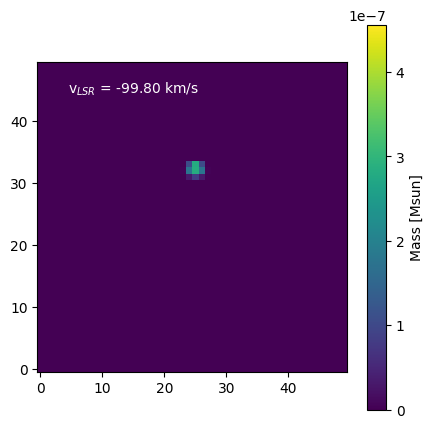

In [24]:
# TODO: add this function in BowshockCube as a method
chan = -10
fig = plt.figure(figsize=(5,5))

ax = plt.subplot()
im = ax.imshow(
    bsc.cube[chan],
    origin="lower",
    vmax=np.max(bsc.cube),
    vmin=np.min(bsc.cube)
)

ax.text(0.1, 0.9, f"v$_{{LSR}}$ = {bsc.velchans[chan]+bsc.vsys:.2f} km/s",color="w", transform=ax.transAxes)
plt.colorbar(im, label="Mass [Msun]")

In [37]:
100 * np.abs(bsc.mass - np.sum(bsc.cube)) / bsc.mass

np.float64(1.844528622739785)

In [38]:
np.sum(bsc.cube)

np.float64(0.0002267391388814711)

In [39]:
bsc.mass

0.000231

In [40]:
np.isclose(bsc.mass, np.sum(bsc.cube))

np.False_

In [41]:
100 * np.abs(bsc.mass - np.sum(bsc.cube)) / bsc.mass

np.float64(1.844528622739785)

In [42]:
bs.CubeProcessing?

Init signature:
bs.CubeProcessing(
    bscube,
    J='3-2',
    XCO=8.5e-05,
    meanmass=<Quantity 4.64884609e-24 g>,
    Tex=<Quantity 100. K>,
    Tbg=<Quantity 2.7 K>,
    coordcube='offset',
    ra_source_deg=None,
    dec_source_deg=None,
    bmin=None,
    bmaj=None,
    pabeam=None,
    papv=None,
    parot=None,
    sigma_beforeconv=None,
    maxcube2noise=None,
    **kwargs,
)
Docstring:     
Process a BowshockCube instance

Parameters:
-----------
File:           ~/py_envs/bowpy/lib/python3.10/site-packages/bowshockpy/bsmodels.py
Type:           type
Subclasses:     

In [25]:
bscs = bs.CubeProcessing(
    bsc,
    J="3-2",
    XCO=8.5*10**(-5),
    meanmass=2.8 / (6.023*10**23) * u.g,
    Tex=100*u.K,
    Tbg=2.7*u.K,
    coordcube="offset",
    ra_source_deg=None,
    dec_source_deg=None,
    bmaj = 0.420,
    bmin = 0.287,
    pabeam = -2.2,
    papv=bsc.pa,
    parot=0,
    sigma_beforeconv=0.05,
    maxcube2noise=0.07,

)

In [34]:
bscs.convolve()


Convolving m_c... 

m_c has been convolved with a gaussian kernel with a size of [2.87, 4.20] pix and with a PA of -2.20deg



In [36]:
bscs.savecube("m")

models/example/fits/m.fits saved


In [39]:
type(bscs.hdrs["m"])

astropy.io.fits.header.Header

In [41]:
type(bscs.beamarea_sr)

astropy.units.quantity.Quantity

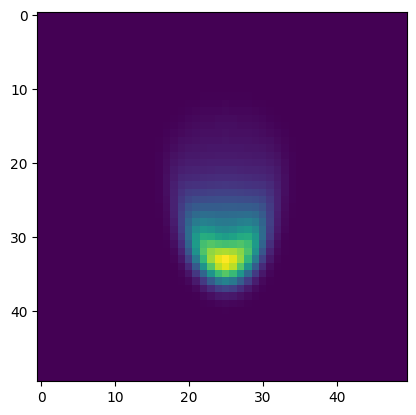

In [52]:
plt.imshow(bscs.cubes["m_c"][5])

In [54]:
outcubes = {
    "intensity": ["add_noise", "convolve", "moments_and_pv"],
    "opacity": [],
    "CO_column_density": [],
    "mass": [],
    }

bscs.calc(outcubes)


Computing column densities...
CO column densities has been calculated


Computing opacities...
Opacities has been calculated


Computing intensities...
Intensities has been calculated


Adding noise to I_n...
Noise added to I_n


Convolving I_nc... 

I_nc has been convolved with a gaussian kernel with a size of [2.87, 4.20] pix and with a PA of -2.20deg


The rms of the convolved image is 0.010516 Jy/beam



In [43]:

mom1 = bscs.mom1(
            "m",
            chan_range=[0, bscs.nc],
            save=True,
        )

models/example/fits/m_mom1.fits saved


models/example/fits/m_c_mom1.fits saved


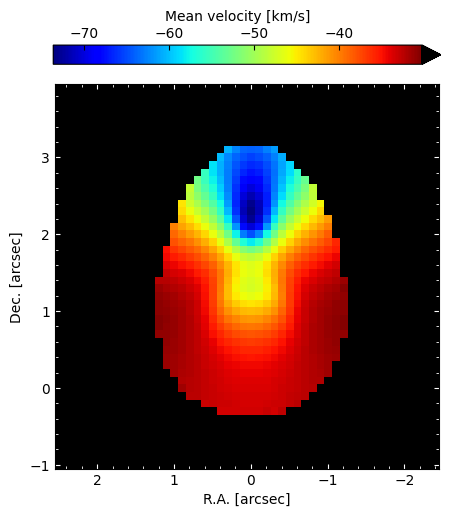

In [50]:
ck = "m_c"
mom1 = bscs.mom1(
            ck,
            chan_range=[0, bscs.nc],
            save=True,
        )

extent = np.array([
    -(-0.5-bscs.refpixs[ck][0]),
    -(bscs.nxs-0.5-bscs.refpixs[ck][0]),
    (-0.5-bscs.refpixs[ck][1]),
    (bscs.nys-0.5-bscs.refpixs[ck][1]),
    ]) * bscs.arcsecpix

ax = bscs.plotmom1(
    mom1,
    extent=extent,
    interpolation=None,
    cbarlabel="Mean velocity [km/s]",
    return_velcmap=True,
    )

In [51]:
type(ax)

matplotlib.colors.ListedColormap

In [ ]:
bscs.mom1plot(
            "m",
            chan_range=[0, bscs.nc],
            save=True,
        )

In [44]:
mom1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(50, 50))

In [ ]:
bsmobs = bs.ObsModel(ps, psobs)

pscube = {
    "nphis": 500,   
    "nc": 50,
    "vt": "2xchannel",
    "vch0": 0, # center value
    "vchf": -150, # center value   
    "nxs": 35 ,
    "nys": 35 , 
    "refpix": [5, 15], 
    "xpmax": 5,    
    "pa": 160,
    "bmaj": 0.420,
    "bmin": 0.287,
    "pabeam": -2.2,
    "CIC": True,
    "tolfactor_vt":2,
    "maxcube2noise": 10,
    "verbose": True,
}
pscube["chanwidth"] = (pscube["vchf"] - pscube["vch0"]) / (pscube["nc"]-1)
pscube["abschanwidth"] = np.abs(pscube["chanwidth"])
pscube["vt"] = pscube["vt"] if type(pscube["vt"])!=str \
      else float(pscube["vt"].split("x")[0])*pscube["chanwidth"]
pscube["arcsecpix"] = pscube["xpmax"] / float(pscube["nxs"])
pscube["x_FWHM"] = pscube["bmin"] / pscube["arcsecpix"]
pscube["y_FWHM"] = pscube["bmaj"] / pscube["arcsecpix"]
pscube["beamarea"] = np.pi * pscube["y_FWHM"] * pscube["x_FWHM"] / (4 * np.log(2))
if pscube["refpix"] == None:
    if pscube["nxs"]%2 == 0:
        xref = pscube["nxs"] / 2
    else:
        xref = (pscube["nxs"]-1) / 2
    if pscube["nys"]%2 == 0:
        yref = pscube["nys"] / 2
    else:
        yref = (pscube["nys"]-1) / 2
    pscube["refpix"] = [xref, yref]

vla4b_skycoords = SkyCoord(ra='03h29m3.7684s', dec='31d16m3.776s', frame='icrs')
ra_source_deg = vla4b_skycoords.ra.deg
dec_source_deg = vla4b_skycoords.dec.deg
mpars = {
    "muH2": 2.8, # Mean molecular mass per H molecule
    "XCO": 8.5*10**(-5),
    "Tex": 100*u.K,
    "Tbg": 2.7*u.K,
    "ra_source_deg": ra_source_deg,
    "dec_source_deg": dec_source_deg
}
mpars["meanmass"] = mpars["muH2"] / (6.023*10**23) * u.g



In [9]:
bsc = bs.BowshockCube(ps, psobs, pscube)
bsc.makecube()

bscs = bs.CubeProcessing(bsc, mpars)
bscs.calc(["m_src"])
#bscs.add_source()
#bscs.rotate()
# bscs.calc_NCO()
# bscs.calc_tau()
# bscs.calc_I()
# for ck in ["NCO", "tau", "I"]:
#     bscs.savecube(ck)



Computing masses...
  0──────────────────────────────────────────────────)100.0% | 84/95s

Adding source to m_s...
m_s has been added a source in pix [5.00, 15.00] pix


Rotatng m_sr...
m_sr has been rotated to a PA = 160 deg


Convolving m_src... 
m_src has been convolved with a gaussian kernel [2.01, 2.94] pix and a PA of -2.20deg



In [10]:
bscs.rotate(ck="m_sr", forpv=True)
bscs.rotate(ck="m_src", forpv=True)


Rotatng m_srR in order to compute the PV diagram...
m_srR has been rotated to a PA = 160 deg


Rotatng m_srcR in order to compute the PV diagram...
m_srcR has been rotated to a PA = 160 deg



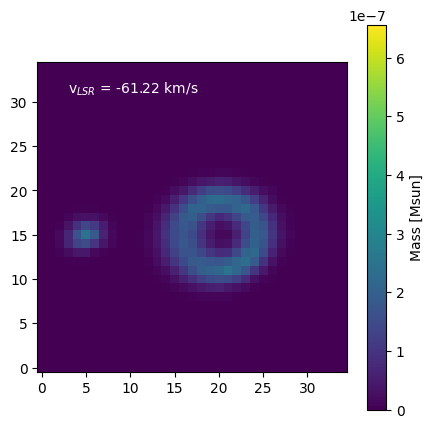

In [11]:
ck = "m_srcR"
chan = 20 
fig = plt.figure(figsize=(5,5))

ax = plt.subplot()
im = ax.imshow(
    bscs.cubes[ck][chan],
    origin="lower",
    vmax=np.max(bscs.cubes[ck]),
    vmin=np.min(bscs.cubes[ck])
)

ax.text(0.1, 0.9, f"v$_{{LSR}}$ = {bscs.velchans[chan]:.2f} km/s",color="w", transform=ax.transAxes)
plt.colorbar(im, label="Mass [Msun]")

models/bs1_240724-124710/fits/m_srR_pv.fits saved


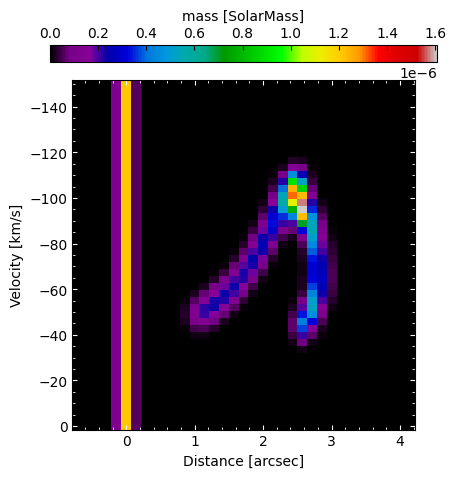

In [12]:
ck = "m_srR"
pvimage = bscs.pvalongz(
    ck, halfwidth=0, save=True,
    )

rangex = np.array([
    -0.5-bscs.refpixs[ck][0],
    bscs.nxs-0.5-bscs.refpixs[ck][0]
    ]) * bscs.arcsecpix

chan_vels = bscs.velchans
bscs.plotpv(
    pvimage,
    rangex=rangex,
    chan_vels=chan_vels,
    cbarlabel=bscs.getunitlabel(ck),
    interpolation=None,
    )

models/bs1_240724-124710/fits/m_sr_sumint.fits saved


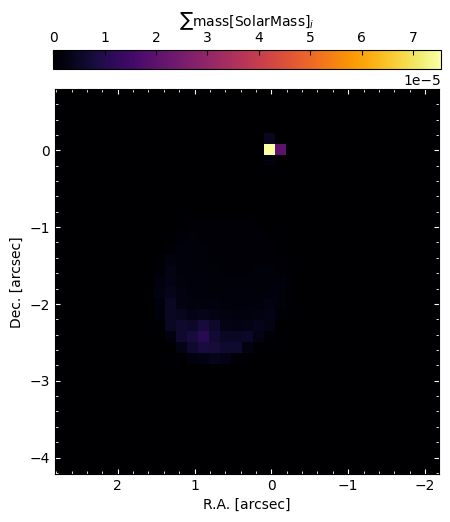

In [13]:
ck = "m_sr"

sumintimage = bscs.sumint(
    ck,
    chan_range=[0, bscs.nc],
    save=True,
    )

extent = np.array([
    -(-0.5-bscs.refpixs[ck][0]),
    -(bscs.nxs-0.5-bscs.refpixs[ck][0]),
    (-0.5-bscs.refpixs[ck][1]),
    (bscs.nys-0.5-bscs.refpixs[ck][1]),
    ]) * bscs.arcsecpix

bscs.plotsumint(
    sumintimage,
    extent=extent,
    interpolation=None,
    cbarlabel=bscs.getunitlabel(ck),
    )


models/bs1_240724-124710/fits/m_sr_mom0.fits saved


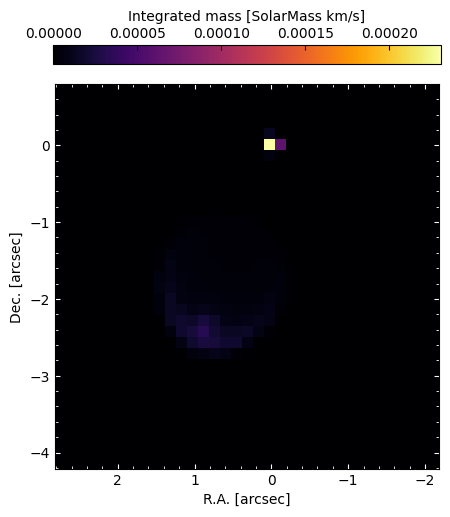

In [14]:
ck = "m_sr"

chan_vels = bscs.velchans
mom0 = bscs.mom0(
    ck,
    chan_range=[0, bscs.nc],
    save=True,
    )

extent = np.array([
    -(-0.5-bscs.refpixs[ck][0]),
    -(bscs.nxs-0.5-bscs.refpixs[ck][0]),
    (-0.5-bscs.refpixs[ck][1]),
    (bscs.nys-0.5-bscs.refpixs[ck][1]),
    ]) * bscs.arcsecpix

bscs.plotmom0(
    mom0,
    extent=extent,
    interpolation=None,
    cbarlabel="Integrated " + bscs.getunitlabel(ck).rstrip("]") + " km/s]"
    )


/mnt/hdd/L1448/bowshockpy/bowpy/moments.py:21: RuntimeWarning: invalid value encountered in divide
  return sumIixvi(cube, chan_vels, chan_range) / sumint(cube, chan_range)


models/bs1_240724-124710/fits/m_sr_mom1.fits saved


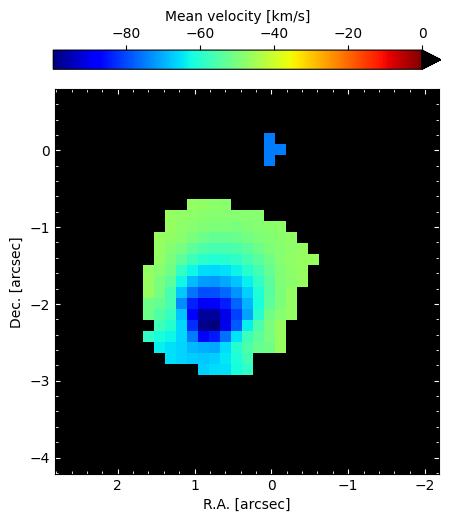

In [15]:
ck = "m_sr"

mom1 = bscs.mom1(
            ck,
            chan_range=[0, bscs.nc],
            save=True,
        )

extent = np.array([
    -(-0.5-bscs.refpixs[ck][0]),
    -(bscs.nxs-0.5-bscs.refpixs[ck][0]),
    (-0.5-bscs.refpixs[ck][1]),
    (bscs.nys-0.5-bscs.refpixs[ck][1]),
    ]) * bscs.arcsecpix

bscs.plotmom1(
    mom1,
    extent=extent,
    interpolation=None,
    cbarlabel="Mean velocity [km/s]"
    )

/mnt/hdd/L1448/bowshockpy/bowpy/moments.py:33: RuntimeWarning: invalid value encountered in divide
  disp = np.sqrt(sumIixvi(cube, chan_vels, chan_range, exp=2)


models/bs1_240724-124710/fits/m_sr_mom2.fits saved


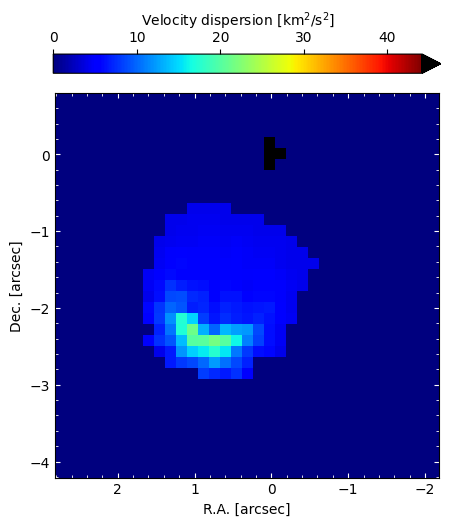

In [16]:
ck = "m_sr"

mom2 = bscs.mom2(
            ck,
            chan_range=[0, bscs.nc],
            save=True,
        )

extent = np.array([
    -(-0.5-bscs.refpixs[ck][0]),
    -(bscs.nxs-0.5-bscs.refpixs[ck][0]),
    (-0.5-bscs.refpixs[ck][1]),
    (bscs.nys-0.5-bscs.refpixs[ck][1]),
    ]) * bscs.arcsecpix

bscs.plotmom2(
    mom2,
    extent=extent,
    interpolation=None,
    cbarlabel="Velocity dispersion [km$^2$/s$^2$]"
    )

models/bs1_240724-124710/fits/m_sr_mom8.fits saved


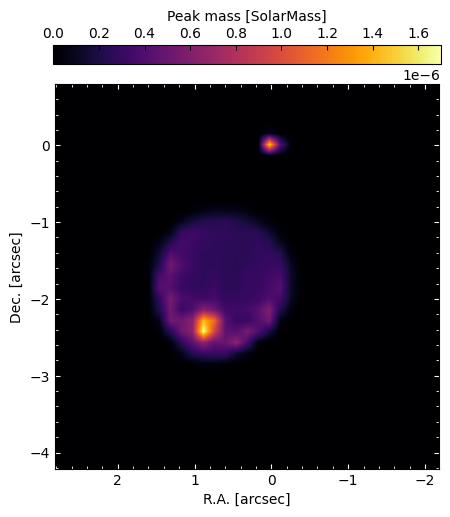

In [17]:
ck = "m_sr"

mom8 = bscs.mom8(
            ck,
            chan_range=[0, bscs.nc],
            save=True,
        )

extent = np.array([
    -(-0.5-bscs.refpixs[ck][0]),
    -(bscs.nxs-0.5-bscs.refpixs[ck][0]),
    (-0.5-bscs.refpixs[ck][1]),
    (bscs.nys-0.5-bscs.refpixs[ck][1]),
    ]) * bscs.arcsecpix

bscs.plotmom8(
    mom8,
    extent=extent,
    cbarlabel="Peak " + bscs.getunitlabel(ck)
    )



Computing moments and the PV-diagram along the jet axis

models/bs1_240724-124710/fits/m_sr_mom0.fits saved
models/bs1_240724-124710/fits/m_sr_mom1.fits saved
models/bs1_240724-124710/fits/m_sr_mom2.fits saved
models/bs1_240724-124710/fits/m_srR_pv.fits saved
models/bs1_240724-124710/fits/m_sr_mom8.fits saved


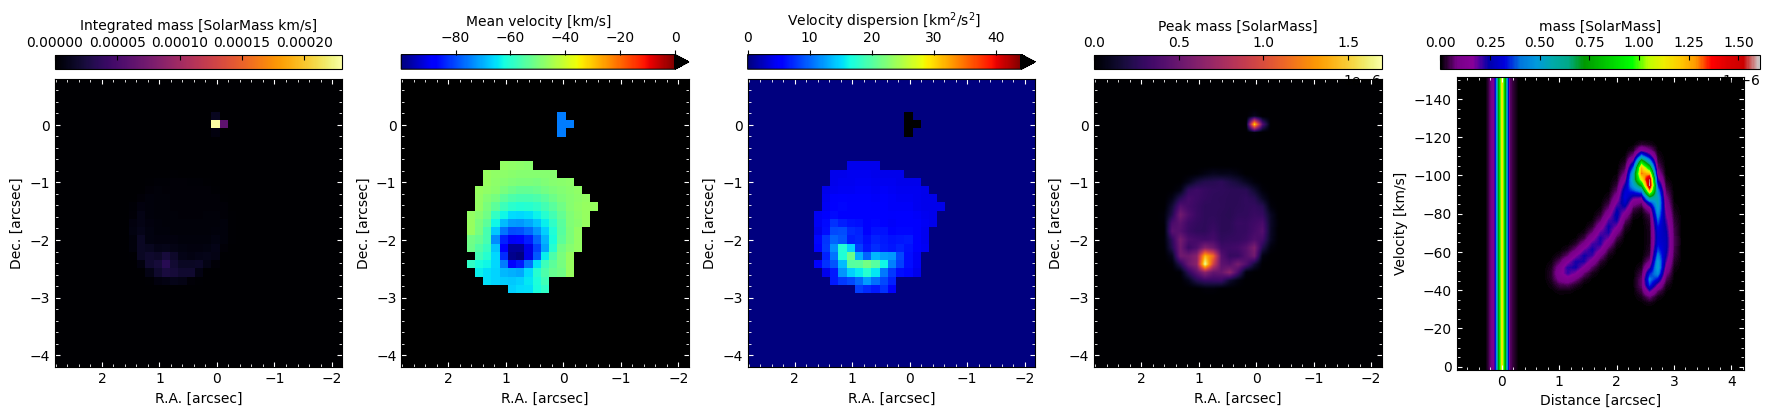

In [18]:
bscs.momentsandpv("m_sr", savefits=True, saveplot=True)

In [ ]:
axtext = 
fr"""
{p.modelname}
Number of bowshocks: {p.nbowshocks}
Tex = {p.Tex}
$i = {[{{p.i*180/np.pi:.2f}} for i in ]}^\circ$
$V_\mathrm{{jet}} = {{{p.vj:.2f}}}$ km/s
$V_0 = {{{p.v0:.2f}}}$ km/s
$V_w = {{{p.vw:.2f}}}$ km/s
$L_0 = {{{p.L0_arcsec:.2f}}}$ arcsec
$z_\mathrm{{jet}} = {{{p.zj_arcsec:.2f}}}$ arcsec
$r_\mathrm{{b,f}} = {{{p.rbf_arcsec:.2f}}}$ arcsec
$t_\mathrm{{jet}} = {{{p.tj_yr:.2f}}}$ yr
$\rho_w = {{{self.rhow_gcm3*10**20:.2f}}}\times 10^{{-20}}$ g cm$^{{-3}}$
$\dot{{m}}_0 = {{{self.mp0_solmassyr*10**6:.2f}}}\times10^{{-6}}$ M$_\odot$ yr$^{{-1}}$
$\dot{{m}}_{{w,f}} = {{{self.mpamb_f_solmassyr*10**6:.2f}}}\times10^{{-6}}$ M$_\odot$ yr$^{{-1}}$
"""


In [124]:
import importlib
bpf_str = input(
"""
Enter the name of the file where the parameters are defined (default: bowshock_params): 
"""
)
bpf_str = bpf_str if bpf_str!="" else "bowshock_params"
p = importlib.import_module(bpf_str.strip(".py"))
print(
f"""
Parameters read from {bpf_str}.py
"""
)


Parameters read from bowshock_params.py



In [75]:
def momentsandpv_params(bscs):
    mom1clipping=0
    mom2clipping=0
    verbose=True,
    mom0values={v: None for v in ["vmax", "vcenter", "vmin"]}
    mom1values={v: None for v in ["vmax", "vcenter", "vmin"]}
    mom2values={v: None for v in ["vmax", "vcenter", "vmin"]}
    mom8values={v: None for v in ["vmax", "vcenter", "vmin"]}
    pvvalues={v: None for v in ["vmax", "vcenter", "vmin"]}
    
    ckpv = ck + "R" 
    if ckpv not in self.cubes:
        self.rotate(ck, forpv=True)
    
    fig = plt.figure(figsize=(14,10))
    gs = GridSpec(
        2, 3,
        width_ratios=[1]*3, # + [0.85]*2,
        height_ratios=[1]*2,
        hspace=0.3,
        wspace=0.25,
    )
    axs = {}
    cbaxs = {}
    gss = {}
   
    ik = "text"
    axs[ik] = plt.subplot(gs[0,0])
    axs[ik].set_axis_off()
    
    ik = "mom0"
    gss[ik] = gs[0,1].subgridspec(
             2, 1,
             height_ratios=[0.05, 1],
             width_ratios=[1],
             hspace=0.05,
         )
    axs[ik] = plt.subplot(gss[ik][1,0])
    cbaxs[ik] = plt.subplot(gss[ik][0,0])
    
    ik = "mom8"
    gss[ik] = gs[0,2].subgridspec(
             2, 1,
             height_ratios=[0.05, 1],
             width_ratios=[1],
             hspace=0.05,
         )
    axs[ik] = plt.subplot(gss[ik][1,0])
    cbaxs[ik] = plt.subplot(gss[ik][0,0])
    
    ik = "pv"
    gss[ik] = gs[1,0].subgridspec(
             2, 1,
             height_ratios=[0.05, 1],
             width_ratios=[1],
             hspace=0.05,
         )
    axs[ik] = plt.subplot(gss[ik][1,0])
    cbaxs[ik] = plt.subplot(gss[ik][0,0])
    
    
    ik = "mom1"
    gss[ik] = gs[1,1].subgridspec(
             2, 1,
             height_ratios=[0.05, 1],
             width_ratios=[1],
             hspace=0.05,
         )
    axs[ik] = plt.subplot(gss[ik][1,0])
    cbaxs[ik] = plt.subplot(gss[ik][0,0])
    
    ik = "mom2"
    gss[ik] = gs[1,2].subgridspec(
             2, 1,
             height_ratios=[0.05, 1],
             width_ratios=[1],
             hspace=0.05,
         )
    axs[ik] = plt.subplot(gss[ik][1,0])
    cbaxs[ik] = plt.subplot(gss[ik][0,0])
    
    ak = "text"
    # ies = [p.__getattribute__(f"i_{i+1}")*180/np.pi for i in range(p.nbowshocks)]
    # rjs = [p.__getattribute__(f"rj_{i+1}") for i in range(p.nbowshocks)]
    # L0s = [p.__getattribute__(f"L0_{i+1}") for i in range(p.nbowshocks)]
    # zjs = [p.__getattribute__(f"zj_{i+1}") for i in range(p.nbowshocks)]
    # vjs = [p.__getattribute__(f"vj_{i+1}") for i in range(p.nbowshocks)]
    # vws = [p.__getattribute__(f"vw_{i+1}") for i in range(p.nbowshocks)]
    # v0s = [p.__getattribute__(f"vw_{i+1}") for i in range(p.nbowshocks)]
    # rbf_obss = [p.__getattribute__(f"rbf_obs_{i+1}") for i in range(p.nbowshocks)]
    # masss = [p.__getattribute__(f"mass_{i+1}") for i in range(p.nbowshocks)]

    ies = [bsc.i*180/np.pi for bsc in bscs]
    Texs = [bsc.Tex for bsc in bscs]
    #rjs = [bsc.rj for bsc in bscs]
    L0s = [bsc.L0_arcsec for bsc in bscs]
    zjs = [bsc.zj_arcsec for bsc in bscs]
    vjs = [bsc.vj for bsc in bscs]
    vws = [bsc.vw for bsc in bscs]
    v0s = [bsc.v0 for bsc in bscs]
    rbfs = [bsc.rbf_arcsec for bsc in bscs]
    tjyrs = [bsc.tjyrs for bsc in bscs]
    # masss = [bsc.mass for bsc in bscs]
    rhows = [bsc.rhow_gcm3*10**20 for bsc in bscs]
    m0s = [bsc.mp0_solmassyr*10**6 for bsc in bscs]
    mwfs = [bsc.mpamb_f_solmassyr*10**6 for bsc in bscs]


    showtext = \
    f"""
    {p.modelname}
    Number of bowshocks: {len(bscs)}
    Tex = {ut.list2str([Texs])} K
    $i = {{{ut.list2str([ies])}}}^\circ$
    $V_\mathrm{{jet}} = {{{ut.list2str(vjs)}}}$ km/s
    $V_0 = {{{ut.list2str(v0s)}}}$ km/s
    $V_w = {{{ut.list2str(vws)}}}$ km/s
    $L_0 = {{{ut.list2str(L0s)}}}$ arcsec
    $z_\mathrm{{jet}} = {{{ut.list2str(zjs)}}}$ arcsec
    $r_\mathrm{{b,f}} = {{{ut.list2str(rbfs)}}}$ arcsec
    $t_\mathrm{{jet}} = {{{ut.list2str(tjyrs)}}}$ yr
    $\rho_w = {{{ut.list2str(rhows)}}}\times 10^{{-20}}$ g cm$^{{-3}}$
    $\dot{{m}}_0 = {{{ut.list2str(m0s)}}}\times10^{{-6}}$ M$_\odot$ yr$^{{-1}}$
    $\dot{{m}}_{{w,f}} = {{{ut.list2str(mwfs)}}}\times10^{{-6}}$ M$_\odot$ yr$^{{-1}}$
    """
    for n, line in enumerate(showtext.split("\n")):
        axs["text"].text(0, 0.99-0.07*n, line, fontsize=12,
                          transform=axs["text"].transAxes)
    
    ak = "mom0"
    mom0 = self.mom0(
        ck,
        chan_range=[0, self.nc],
        save=False,
        )
    extent = np.array([
        -(-0.5-self.refpixs[ck][0]),
        -(self.nxs-0.5-self.refpixs[ck][0]),
        (-0.5-self.refpixs[ck][1]),
        (self.nys-0.5-self.refpixs[ck][1]),
        ]) * self.arcsecpix
    self.plotmom0(
        mom0,
        extent=extent,
        interpolation=None,
        ax=axs[ak],
        cbax=cbaxs[ak],
        cbarlabel="Integrated " + self.getunitlabel(ck).rstrip("]") + " km/s]",
        **mom0values,
        )
    
    ak = "mom1"
    clipping = float(mom1clipping.split("x")[0]) * self.sigma_noises[ck] \
        if mom1clipping !=0 else 0
    mom1 = self.mom1(
                ck,
                chan_range=[0, self.nc], 
                save=False,
                clipping=clipping,
            )
    extent = np.array([
        -(-0.5-self.refpixs[ck][0]),
        -(self.nxs-0.5-self.refpixs[ck][0]),
        (-0.5-self.refpixs[ck][1]),
        (self.nys-0.5-self.refpixs[ck][1]),
        ]) * self.arcsecpix
    self.plotmom1(
        mom1,
        extent=extent,
        interpolation=None,
        ax=axs[ak],
        cbax=cbaxs[ak],
        cbarlabel="Mean velocity [km/s]",
        **mom1values,
        )
    
    ak = "mom2"
    clipping = float(mom2clipping.split("x")[0]) * self.sigma_noises[ck]\
        if mom1clipping !=0 else 0
    mom2 = self.mom2(
                ck,
                chan_range=[0, self.nc], 
                save=False,
                clipping=clipping,
            )
    extent = np.array([
        -(-0.5-self.refpixs[ck][0]),
        -(self.nxs-0.5-self.refpixs[ck][0]),
        (-0.5-self.refpixs[ck][1]),
        (self.nys-0.5-self.refpixs[ck][1]),
        ]) * self.arcsecpix
    self.plotmom2(
        mom2,
        extent=extent,
        interpolation=None,
        ax=axs[ak],
        cbax=cbaxs[ak],
        cbarlabel="Velocity dispersion [km$^2$/s$^2$]",
        **mom2values,
        )
    
    ak = "pv"
    pvimage = self.pvalongz(
        ckpv,
        halfwidth=0,
        save=False,
        )
    rangex = np.array([
        -0.5-self.refpixs[ckpv][0],
        self.nxs-0.5-self.refpixs[ckpv][0]
        ]) * self.arcsecpix
    chan_vels = self.velchans
    self.plotpv(
        pvimage,
        rangex=rangex,
        chan_vels=chan_vels,
        ax=axs[ak],
        cbax=cbaxs[ak],
        cbarlabel=self.getunitlabel(ckpv),
        **pvvalues,
        )
    #axs[ak].set_aspect(np.abs(np.diff(rangex))/np.abs((chan_vels[0]-chan_vels[-1])) * 0.9)
    
    ak = "mom8"
    mom8 = self.mom8(
                ck,
                chan_range=[0, self.nc],
                save=False,
            )
    extent = np.array([
        -(-0.5-self.refpixs[ck][0]),
        -(self.nxs-0.5-self.refpixs[ck][0]),
        (-0.5-self.refpixs[ck][1]),
        (self.nys-0.5-self.refpixs[ck][1]),
        ]) * self.arcsecpix
    self.plotmom8(
        mom8,
        extent=extent,
        ax=axs[ak],
        cbax=cbaxs[ak],
        cbarlabel="Peak " + self.getunitlabel(ck),
        **mom8values,
        )

In [120]:
def list2str(a, precision=2):
    return str([float(f'{i:.{precision}f}') for i in a])

In [121]:
a = [3.13, 2.12, 1.01, 0.32, 5.12]
showtext = \
fr"""
$a = {{{list2str(a)}}}$
b = 
"""


/mnt/hdd/L1448/bowshockpy/bowpy/moments.py:21: RuntimeWarning: invalid value encountered in divide
  return sumIixvi(cube, chan_vels, chan_range) / sumint(cube, chan_range)
/mnt/hdd/L1448/bowshockpy/bowpy/moments.py:33: RuntimeWarning: invalid value encountered in divide
  disp = np.sqrt(sumIixvi(cube, chan_vels, chan_range, exp=2)


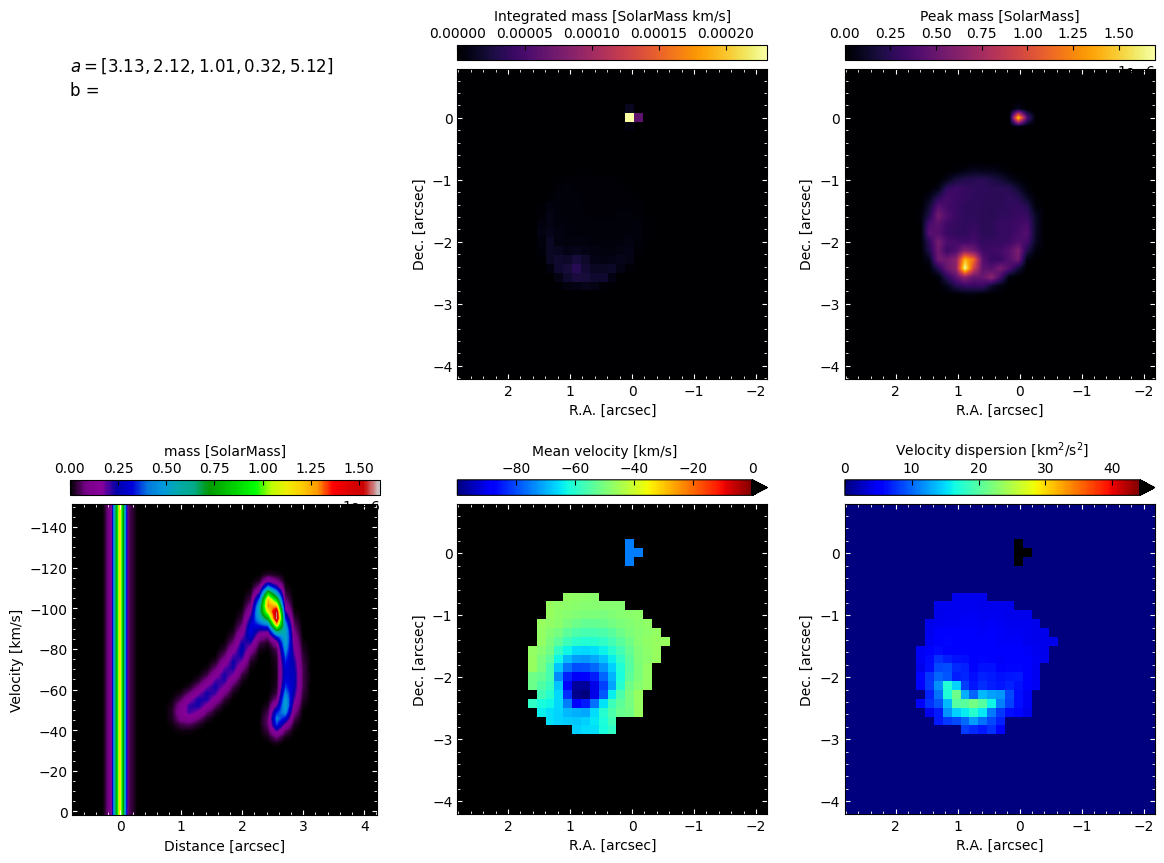

In [122]:
momentsandpv_params(showtext)

In [58]:
a = [1, 2, 3, 4]
b = [1, 2, 3, 4]
for i, (k,p) in enumerate(zip(a, b)):
    print(i, k, p)

0 1 1
1 2 2
2 3 3
3 4 4


In [66]:
print(
f"""
i = {[float(f'{i:.2f}') for i in a]}
b = {[float(f'{i:.2f}') for i in a]}
"""
)


i = [1.0, 2.0, 3.0, 4.0]
b = [1.0, 2.0, 3.0, 4.0]



In [56]:
np.array([a, b]).ravel()

array([1, 2, 3, 4, 1, 2, 3, 4])

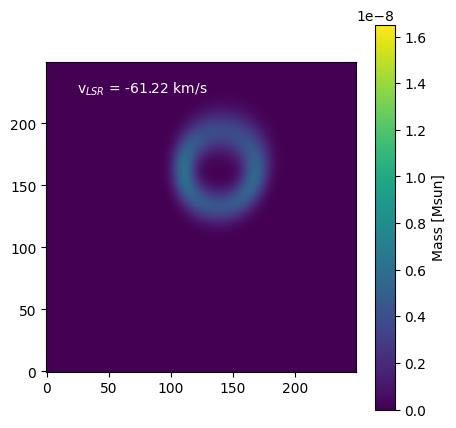

In [22]:
ck = "m_rc"
chan = 20 
fig = plt.figure(figsize=(5,5))

ax = plt.subplot()
im = ax.imshow(
    bscs.cubes[ck][chan],
    origin="lower",
    vmax=np.max(bscs.cubes[ck]),
    vmin=np.min(bscs.cubes[ck])
)

ax.text(0.1, 0.9, f"v$_{{LSR}}$ = {bscs.velchans[chan]:.2f} km/s",color="w", transform=ax.transAxes)
plt.colorbar(im, label="Mass [Msun]")

/mnt/hdd/L1448/bowshockpy/bowpy/moments.py:21: RuntimeWarning: invalid value encountered in divide
  return sumIixvi(cube, chan_vels, chan_range) / sumint(cube, chan_range)


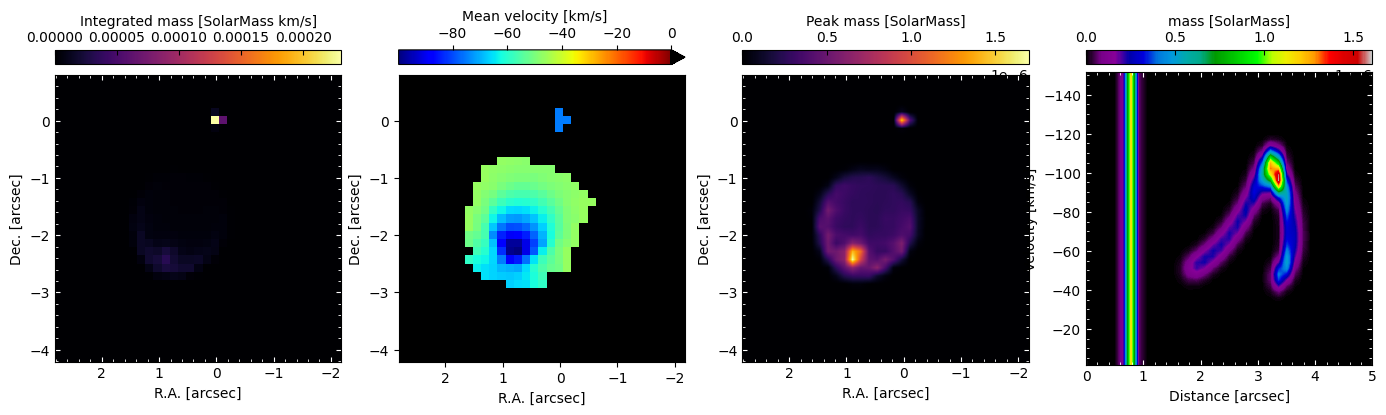

In [122]:
ck = "m_sr"
ckpv = ck + "R" 
fig = plt.figure(figsize=(17,9))
gs = GridSpec(
    2, 4,
    hspace=0.2,
    wspace=0.2,
)

axs = {}
cbaxs = {}
gss = {}

for i, ik in enumerate(["mom0", "mom1", "mom8", "pv"]):
    gss[ik] = gs[0,i].subgridspec(
        2, 1,
        height_ratios=[0.05, 1],
        width_ratios=[1],
        hspace=0.05,
    )
    axs[ik] = plt.subplot(gss[ik][1,0])
    cbaxs[ik] = plt.subplot(gss[ik][0,0])

ak = "mom0"
mom0 = moments.mom0(
    bscs.cubes[ck],
    chan_vels=chan_vels,
    chan_range=[0, bscs.nc]
    )
extent = np.array([
    -(-0.5-bscs.refpixs[ck][0]),
    -(bscs.nxs-0.5-bscs.refpixs[ck][0]),
    (-0.5-bscs.refpixs[ck][1]),
    (bscs.nys-0.5-bscs.refpixs[ck][1]),
    ]) * bscs.arcsecpix
plotmom0(
    mom0,
    extent=extent,
    interpolation=None,
    ax=axs[ak],
    cbax=cbaxs[ak],
    cbarlabel="Integrated " + bscs.getunitlabel(ck).rstrip("]") + " km/s]"
    )

ak = "mom1"
clipping = 0
cube_clipped = np.copy(bscs.cubes[ck])
cube_clipped[cube_clipped<clipping] = 0
mom1 = np.nan_to_num(
        moments.mom1(
            cube_clipped,
            chan_vels=chan_vels,
            chan_range=[0, bscs.nc], 
        )
    )
extent = np.array([
    -(-0.5-bscs.refpixs[ck][0]),
    -(bscs.nxs-0.5-bscs.refpixs[ck][0]),
    (-0.5-bscs.refpixs[ck][1]),
    (bscs.nys-0.5-bscs.refpixs[ck][1]),
    ]) * bscs.arcsecpix
plotmom1(
    mom1,
    extent=extent,
    interpolation=None,
    ax=axs[ak],
    cbax=cbaxs[ak],
    cbarlabel="Mean velocity [km/s]"
    )

ak = "pv"
pvimage = moments.pv(
    bscs.cubes[ckpv],
    int(bscs.refpixs[ckpv][1]),
    halfwidth=0, axis=1
    )
rangex = np.array([0, bscs.arcsecpix*np.shape(pvimage)[1]])
chan_vels = bscs.velchans
plotpv(
    pvimage,
    rangex=rangex,
    chan_vels=chan_vels,
    ax=axs[ak],
    cbax=cbaxs[ak],
    cbarlabel=bscs.getunitlabel(ckpv),
    )

ak = "mom8"
clipping = 0
cube_clipped = np.copy(bscs.cubes[ck])
cube_clipped[cube_clipped<clipping] = 0
mom8 = np.nan_to_num(
        moments.mom8(
            cube_clipped,
            chan_range=[0, bscs.nc]
        )
    )
extent = np.array([
    -(-0.5-bscs.refpixs[ck][0]),
    -(bscs.nxs-0.5-bscs.refpixs[ck][0]),
    (-0.5-bscs.refpixs[ck][1]),
    (bscs.nys-0.5-bscs.refpixs[ck][1]),
    ]) * bscs.arcsecpix
plotmom8(
    mom8,
    extent=extent,
    ax=axs[ak],
    cbax=cbaxs[ak],
    cbarlabel="Peak " + bscs.getunitlabel(ck)
    )

bsc.fig_model.savefig(f"models/{ps['modelname']}/2D.pdf")

KeyError: 'm_r'

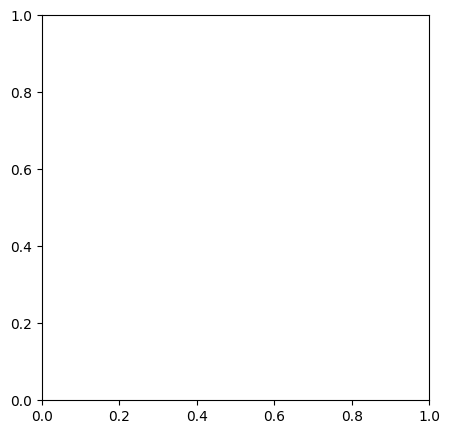

In [16]:
ck = "m_r"
chan = 20 
fig = plt.figure(figsize=(5,5))

ax = plt.subplot()
im = ax.imshow(
    bscs.cubes[ck][chan],
    origin="lower",
    vmax=np.max(bscs.cubes[ck]),
    vmin=np.min(bscs.cubes[ck])
)

ax.text(0.1, 0.9, f"v$_{{LSR}}$ = {bscs.velchans[chan]:.2f} km/s",color="w", transform=ax.transAxes)
plt.colorbar(im, label="Mass [Msun]")

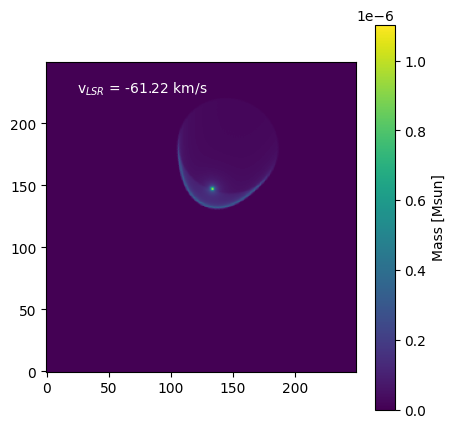

In [64]:
ck = "m_r"
fig = plt.figure(figsize=(5,5))

ax = plt.subplot()
im = ax.imshow(
    np.sum(bscs.cubes[ck], axis=0),
    origin="lower",
)

ax.text(0.1, 0.9, f"v$_{{LSR}}$ = {bscs.velchans[chan]:.2f} km/s",color="w", transform=ax.transAxes)
plt.colorbar(im, label="Mass [Msun]")